# 5 niveaux de RAG

Un RAG (Retrieval-Augmented Generation) est un moteur de recherche enrichi par l‚Äôintelligence artificielle.

C'est un syst√®me complexe compos√© de trois grandes √©tapes¬†:
* L‚Äôingestion : interpr√©tation et traitement d'une requ√™te utilisateur.
* La r√©cup√©ration : extraction des donn√©es pertinentes en fonction du contexte.
* La restitution : g√©n√©ration d'une r√©ponse en langage naturel √† partir des donn√©es r√©cup√©r√©es.

L‚Äôid√©e de ce notebook est de construire un RAG en 5 niveaux de complexit√© croissante, n√©cessitant progressivement plus de puissance de calcul, de temps et de ressources (notamment en cr√©dits API).

Voici les 5 niveaux de RAG :
1. Niveau 1 : RAG na√Øf
R√©cup√©ration simple des documents les plus pertinents et g√©n√©ration d‚Äôune r√©ponse basique.
1. Niveau 2 : RAG avec Multi-Query
G√©n√©ration de plusieurs formulations de la requ√™te initiale pour am√©liorer la couverture du contexte.
1. Niveau 3 : RAG avec FAISS, index stock√© et configurable
Utilisation d‚Äôun moteur de recherche vectoriel (comme FAISS) avec un index persistant et configurable.
1. Niveau 4 : RAG avec Reciprocal Rank Fusion (RRF)
Fusion des r√©sultats de plusieurs requ√™tes pour am√©liorer la qualit√© du classement des documents.
1. Niveau 5 : RAG avec d√©composition de requ√™te et de r√©ponse (Query/Response Decomposition)
Capacit√© √† analyser des requ√™tes complexes, les d√©composer en sous-questions, et synth√©tiser les r√©ponses.


Objectif de la construction de ces 5 niveaux :
* Comprendre les principes fondamentaux du RAG.
* Explorer les possibilit√©s d‚Äôoptimisation √† chaque niveau.
* Mesurer les compromis entre simplicit√©, performance, co√ªt et pertinence.
* Fournir un cadre progressif pour construire un syst√®me RAG robuste et modulaire.

Chaque niveau sera d√©taill√© avec ses fonctionnalit√©s, ses avantages et inconv√©nients, ainsi que les technologies utilis√©es.

## Environment variales

In [ ]:
## --> Add Necessary env variables here


## Pr√©paration de l'environnement de travail

In [ ]:
# Check for GPU
!nvidia-smi

Tue Jun 24 12:07:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# General upgrade
!apt-get update -y && apt-get upgrade -y

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,747 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,253 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packa

In [ ]:
# Install Pytorch
!pip install torch

# Instal TensorFlow (colab GPU)
!pip install tensorflow

# Install Hugging Face Transformers, Datasets, et Diffusers
!pip install transformers datasets diffusers accelerate huggingface_hub

# Install langchain, langgraph
!pip install langchain langchain_ollama langchain_community langchain-nomic langgraph langchain_openai langsmith

!pip install ipywidgets tiktoken "nomic[local]" scikit-learn

# Install other utils
!pip install chromadb diskcache

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.8/13.8 MB 89.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.6/24.6 MB 74.1 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.6/1.6 MB 60.8 MB/s eta 0:00:00
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 67.3/67.3 kB 7.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19.3/19.3 MB 119.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 45.5/45.5 kB 4.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [ ]:
import getpass
import os

if not OPENAI_API_KEY:
 OPENAI_API_KEY = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

# RAG niveau 1

Cette impl√©mentation propose une organisation modulaire d‚Äôun pipeline RAG en utilisant Langraph et une classe Pydantic State pour structurer les flux de donn√©es.

## Pourquoi cette approche ?

‚úÖ Modularit√© : Chaque agent a une responsabilit√© sp√©cifique (ingestion, r√©cup√©ration, restitution).

‚úÖ Utilisation de Langraph : Permet de structurer le pipeline sous forme de graphe d‚Äôex√©cution.

‚úÖ Centralisation de l‚Äô√©tat : Gr√¢ce √† une classe RAGState, toutes les √©tapes partagent leurs donn√©es de mani√®re fluide.

‚úÖ Extensibilit√© : Facile √† enrichir avec de nouvelles fonctionnalit√©s (ex: feedback loop, post-traitement, analyse s√©mantique avanc√©e).

## Limites du RAG niveau 1 (na√Øf)
Cette impl√©mentation correspond √† un RAG de niveau 1 : fonctionnel, mais encore na√Øf dans sa strat√©gie de r√©cup√©ration d‚Äôinformation. Il pr√©sente plusieurs limites importantes :

‚ö†Ô∏è Un seul point de vue par requ√™te
La r√©cup√©ration se base sur une seule formulation de la requ√™te utilisateur. Cela limite fortement la couverture s√©mantique : si la requ√™te est mal formul√©e, peu ou pas de documents pertinents seront trouv√©s.

‚ö†Ô∏è Pas de reformulation intelligente
Le pipeline ne reformule pas dynamiquement les requ√™tes pour explorer diff√©rentes formulations possibles ou synonymes, ce qui peut induire des r√©sultats incomplets.

‚ö†Ô∏è Pas de robustesse face aux ambigu√Øt√©s
Si la question est floue ou ambig√ºe, le syst√®me ne pose pas de clarification, ni n'essaie d'√©largir les angles d‚Äôapproche.

‚ö†Ô∏è Pas de fusion ou agr√©gation avanc√©e des r√©ponses
Une fois les documents r√©cup√©r√©s, la r√©ponse g√©n√©r√©e est bas√©e uniquement sur ce sous-ensemble sans strat√©gie de comparaison, vote, ou condensation multi-sources.

## üèóÔ∏è Organisation du pipeline

Ce pipeline RAG est structur√© autour de plusieurs agents interconnect√©s sous forme de graphe d'ex√©cution dynamique. Chaque agent joue un r√¥le pr√©cis dans la cha√Æne de traitement.

üì• IngestionAgent

* Accepte des sources de types vari√©s : URL web, fichiers locaux (texte, PDF), ou contenus d‚ÄôAPI externes.
* Utilise des loaders sp√©cialis√©s pour extraire les contenus textuels.
* Segmente les documents en morceaux de taille optimale via un d√©coupage s√©mantique (RecursiveCharacterTextSplitter).
* Pr√©pare les documents √† √™tre index√©s dans un espace vectoriel.

üîç RetrievalAgent

* Transforme les documents ing√©r√©s en vecteurs via un mod√®le d'embedding (OpenAI ou Ollama).
* Cr√©e un index vectoriel avec Chroma pour permettre une recherche rapide.
* R√©cup√®re les documents les plus pertinents en fonction d‚Äôune requ√™te utilisateur.
* Pr√©pare ces documents pour le mod√®le de g√©n√©ration sous forme de contexte.

üìù RestitutionAgent

* Utilise un LLM (comme gpt-4o-mini) pour g√©n√©rer une r√©ponse naturelle √† partir du contexte document√©.
* Structure la r√©ponse de mani√®re claire, avec exemples si n√©cessaire.
* S‚Äôappuie sur des templates de prompt pour cadrer la g√©n√©ration.

üíö FeedbackAgent

* Re√ßoit le feedback utilisateur sur la qualit√© de la r√©ponse.
* Analyse s‚Äôil faut reformuler la requ√™te (ex : "pas clair", "ajoute des exemples").
* Relance le pipeline avec une version enrichie de la requ√™te si besoin.
* Permet d‚Äôam√©liorer de mani√®re it√©rative la qualit√© des r√©ponses g√©n√©r√©es.





| üìå Technologie             | üîé R√¥le                                                                                         |
| -------------------------- | ----------------------------------------------------------------------------------------------- |
| **LangChain**              | Orchestration des composants RAG (loaders, embeddings, retrieval, LLM).                         |
| **LangGraph**              | Organisation du pipeline sous forme de graphe d√©claratif (√©tats + transitions conditionnelles). |
| **Pydantic**               | D√©finition du sch√©ma d‚Äô√©tat global (`RAGState`) avec validation automatique.                    |
| **ChromaDB**               | Stockage vectoriel local pour retrouver les documents similaires efficacement.                  |
| **OpenAI / Ollama**        | Fournissent les mod√®les de g√©n√©ration (`ChatOpenAI`, `ChatOllama`) et d‚Äôembedding.              |
| **Markdown / PDF Loaders** | Chargent les contenus √† partir de sources h√©t√©rog√®nes (web, fichiers, APIs).                    |
| **Requests**               | Acc√®s aux donn√©es issues d‚ÄôAPIs REST pour ingestion.                                            |


## Realisation

In [ ]:
import os

from typing import List, Optional
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph
from pydantic import BaseModel
import bs4
from langsmith import traceable, Client
from langchain.callbacks.tracers.langchain import LangChainTracer
from langchain.callbacks.manager import CallbackManager
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader, TextLoader
import requests
from typing import Dict, List, Optional


In [ ]:
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

def get_chat_model(config):
    model_type = "openai"
    model_name = "gpt-4o-mini"
    model_temperature = 0.3
    model_max_retries = 3

    print(f"Selected Configuration:\n"
          f"Model Type: {model_type}\n"
          f"Model Name: {model_name}\n"
          f"Temperature: {model_temperature}\n"
          f"Max Retries: {model_max_retries}")

    if model_type.lower() == "ollama":
        # Return ChatOllama if the model type is "ollama"
        return ChatOllama(
            model=model_name,
            temperature=model_temperature,
            max_retries=model_max_retries
        )
    elif model_type.lower() == "openai":
        # Return ChatOpenAI if the model type is "openai"
        return ChatOpenAI(
            model=model_name,
            temperature=model_temperature,
            max_retries=model_max_retries,
            api_key=OPENAI_API_KEY
        )
    else:
        raise ValueError(f"Unrecognized model type: {model_type}")


def get_embeddings(config):
    model_type = "openai"
    model_name = "text-embedding-3-small"

    print(f"Selected Embedding Configuration:\n"
          f"Embedding Type: {model_type}\n"
          f"Embedding Model: {model_name}")

    if model_type.lower() == "ollama":
        return OllamaEmbeddings(
            model=model_name
        )
    elif model_type.lower() == "openai":
        return OpenAIEmbeddings(
            model=model_name,
            api_key=OPENAI_API_KEY
        )
    else:
        raise ValueError(f"Unrecognized model type: {model_type}")

In [ ]:
#### üèóÔ∏è D√©finition de l'√©tat global ####
class RAGState(BaseModel):
    query: str
    sources: List[Dict[str, str]]  # List[str]
    available_docs: int = 0
    ingested: Optional[List[Document]] = None
    retrieved_docs: Optional[List[str]] = None
    answer: Optional[str] = None
    should_continue: bool = False
    feedback_input: Optional[str] = None

In [ ]:
#### üì• Agent d'Ingestion ####

from langchain.document_loaders import PyPDFLoader, TextLoader
import requests

def ingestion_agent(state: RAGState) -> RAGState:
    all_docs = []

    for source in state.sources:
        src_type = source.get("type")
        path = source.get("path")

        if src_type == "web":
            loader = WebBaseLoader(web_paths=[path])
        elif src_type == "pdf":
            loader = PyPDFLoader(path)
        elif src_type == "file":
            loader = TextLoader(path)
        elif src_type == "api":
            response = requests.get(path)
            if response.status_code == 200:
                content = response.text
                all_docs.append(Document(page_content=content))
                continue
            else:
                print(f"‚ö†Ô∏è API inaccessible : {path}")
                continue
        else:
            print(f"‚ö†Ô∏è Type de source inconnu : {src_type}")
            continue

        docs = loader.load()
        all_docs.extend(docs)

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
    splits = text_splitter.split_documents(all_docs)

    return {"available_docs": len(all_docs), "ingested": splits}

In [ ]:
#### üîç Agent de R√©cup√©ration ####
def retrieval_agent(state: RAGState) -> RAGState:
    if not state.available_docs > 0:
        raise ValueError("Aucun document index√© !")

    target_embedding = get_embeddings({
        "configurable": {
            "embedding_type": "openai",
            "embedding_model": "text-embedding-3-small"
        }
    })

    vectorstore = Chroma.from_documents(documents=state.ingested, embedding=target_embedding)
    retriever = vectorstore.as_retriever()
    docs = retriever.invoke(state.query)

    if not docs:
        print("‚ùå Aucun document pertinent r√©cup√©r√©.")
    else:
        print(f"‚úÖ {len(docs)} document(s) r√©cup√©r√©(s)")

    formatted_docs = "\n\n".join(doc.page_content for doc in docs)
    return {"retrieved_docs": [formatted_docs]}


In [ ]:
#### üìù Agent de Restitution ####
def restitution_agent(state: RAGState) -> RAGState:
    if not state.retrieved_docs:
        raise ValueError("Aucun document r√©cup√©r√© !")

    target_llm = get_chat_model({
        "configurable": {
            "model_type": "openai",
            "model": "gpt-4o-mini",
            "temperature": 0,
            "max_retry": 2
        }
    })

    prompt_template = ChatPromptTemplate.from_template("""
    R√©pondez √† la question en utilisant uniquement le contexte suivant :
    {context}

    Sois pr√©cis et donne des exemples

    Question : {question}
    """)

    chain = prompt_template | target_llm | StrOutputParser()
    response = chain.invoke({
        "context": "\n\n".join(state.retrieved_docs),
        "question": state.query
    })

    return {"answer": response}

In [ ]:
#### üíö Agent de Feedback ####
client = Client()

def feedback_agent(state: RAGState) -> RAGState:
    feedback = state.feedback_input.lower()

    # Si feedback utile, modifier la requ√™te
    if any(word in feedback for word in ["pas clair", "exemple", "vague", "mauvais", "recommence", "pr√©cis"]):
        print(state.query)
        new_query = f"{state.query} (Am√©liore avec des exemples et plus de clart√©, l'utilisateur a dit: '{feedback}')"
        return {
            "query": new_query,
            "should_continue": True,
            "feedback_input": None  # reset
        }

    # Feedback pas utile ou non pertinent
    return {
        "should_continue": False,
        "feedback_input": None
    }




def ask_feedback_agent(state: RAGState) -> RAGState:
    print("üí¨ R√©ponse :", state.answer)
    user_feedback = input("üìù Entrez un feedback (ou laissez vide pour continuer) : ").strip()

    return {
        "feedback_input": user_feedback,
        "should_continue": bool(user_feedback)
    }


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
#### üìå Construction du graphe ####
graph = StateGraph(RAGState)

# Ajout des agents
graph.add_node("ingestion", ingestion_agent)
graph.add_node("retrieval", retrieval_agent)
graph.add_node("restitution", restitution_agent)
graph.add_node("ask_feedback", ask_feedback_agent)
graph.add_node("feedback", feedback_agent)


# Connexion des √©tapes
graph.set_entry_point("ingestion")
graph.add_edge("ingestion", "retrieval")
graph.add_edge("retrieval", "restitution")
graph.add_edge("restitution", "ask_feedback")
graph.add_edge("ask_feedback", "feedback")

# Conditionnelle : soit on relance, soit on termine
graph.add_conditional_edges("feedback", lambda state: "retrieval" if state.should_continue else "end")


# Ex√©cution du pipeline
executor = graph.compile()

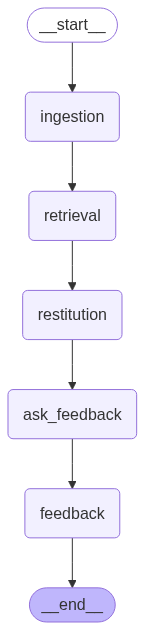

In [ ]:
from IPython.display import Image, display
display(Image(executor.get_graph().draw_mermaid_png()))

In [ ]:
@traceable(name="Full RAG Pipeline")
def run_pipeline(query: str, sources: List[str]) -> RAGState:
    return executor.invoke(RAGState(query=query, sources=sources))

#### üöÄ Test du RAG organis√© avec Langraph + LangSmith ####
query = "Comment utiliser les outils de LangGraph en python ?"
sources = [
    {"type": "web", "path": "https://langchain-ai.github.io/langgraph/tutorials/get-started/2-add-tools/#add-tools"} #,
    # {"type": "file", "path": "./langchain.md"}
]
result = run_pipeline(query, sources)
print("üí¨ R√©ponse :", result['answer'])


Selected Embedding Configuration:
Embedding Type: openai
Embedding Model: text-embedding-3-small
‚úÖ 4 document(s) r√©cup√©r√©(s)
Selected Configuration:
Model Type: openai
Model Name: gpt-4o-mini
Temperature: 0.3
Max Retries: 3
üí¨ R√©ponse : Pour utiliser les outils de LangGraph en Python, vous pouvez suivre ces √©tapes :

1. **Installation de LangGraph** : Assurez-vous d'avoir install√© la biblioth√®que LangGraph. Vous pouvez le faire via pip :
   ```bash
   pip install langgraph
   ```

2. **Utilisation des composants pr√©construits** : LangGraph propose des composants pr√©construits qui facilitent le d√©veloppement. Par exemple, vous pouvez utiliser des composants pour ex√©cuter des API en parall√®le. Voici un exemple de code :
   ```python
   from langgraph import PrebuiltComponent

   # Cr√©ez une instance d'un composant pr√©construit
   component = PrebuiltComponent()

   # Utilisez le composant pour ex√©cuter des t√¢ches
   results = component.execute_parallel(api_calls)
   `

# RAG niveau 2 avec MultiQuery

Cette impl√©mentation propose une organisation modulaire avanc√©e d‚Äôun pipeline Retrieval-Augmented Generation (RAG) en utilisant :
* LangGraph pour orchestrer le flux d‚Äôagents
* Pydantic pour structurer les donn√©es via un RAGState
* Une strat√©gie MultiQuery pour am√©liorer la qualit√© de r√©cup√©ration des documents
* Un syst√®me de cache int√©gr√© pour optimiser les performances


## Pourquoi cette approche ?
‚úÖ Centralisation de l'√©tat : Gr√¢ce √† des classes Pydantic (RAGState, MultiQueryOutput, ResponseFormatter), toutes les √©tapes partagent leurs donn√©es de mani√®re structur√©e.

‚úÖ Robustesse : Utilisation de sorties structur√©es pour chaque √©tape du pipeline.

‚úÖ R√©cup√©ration am√©lior√©e : La strat√©gie MultiQuery explore plusieurs reformulations de la requ√™te pour maximiser la couverture.

‚úÖ Performance optimis√©e : Int√©gration native d‚Äôun cache (requ√™tes fr√©quentes ‚Üí r√©ponses instantan√©es).

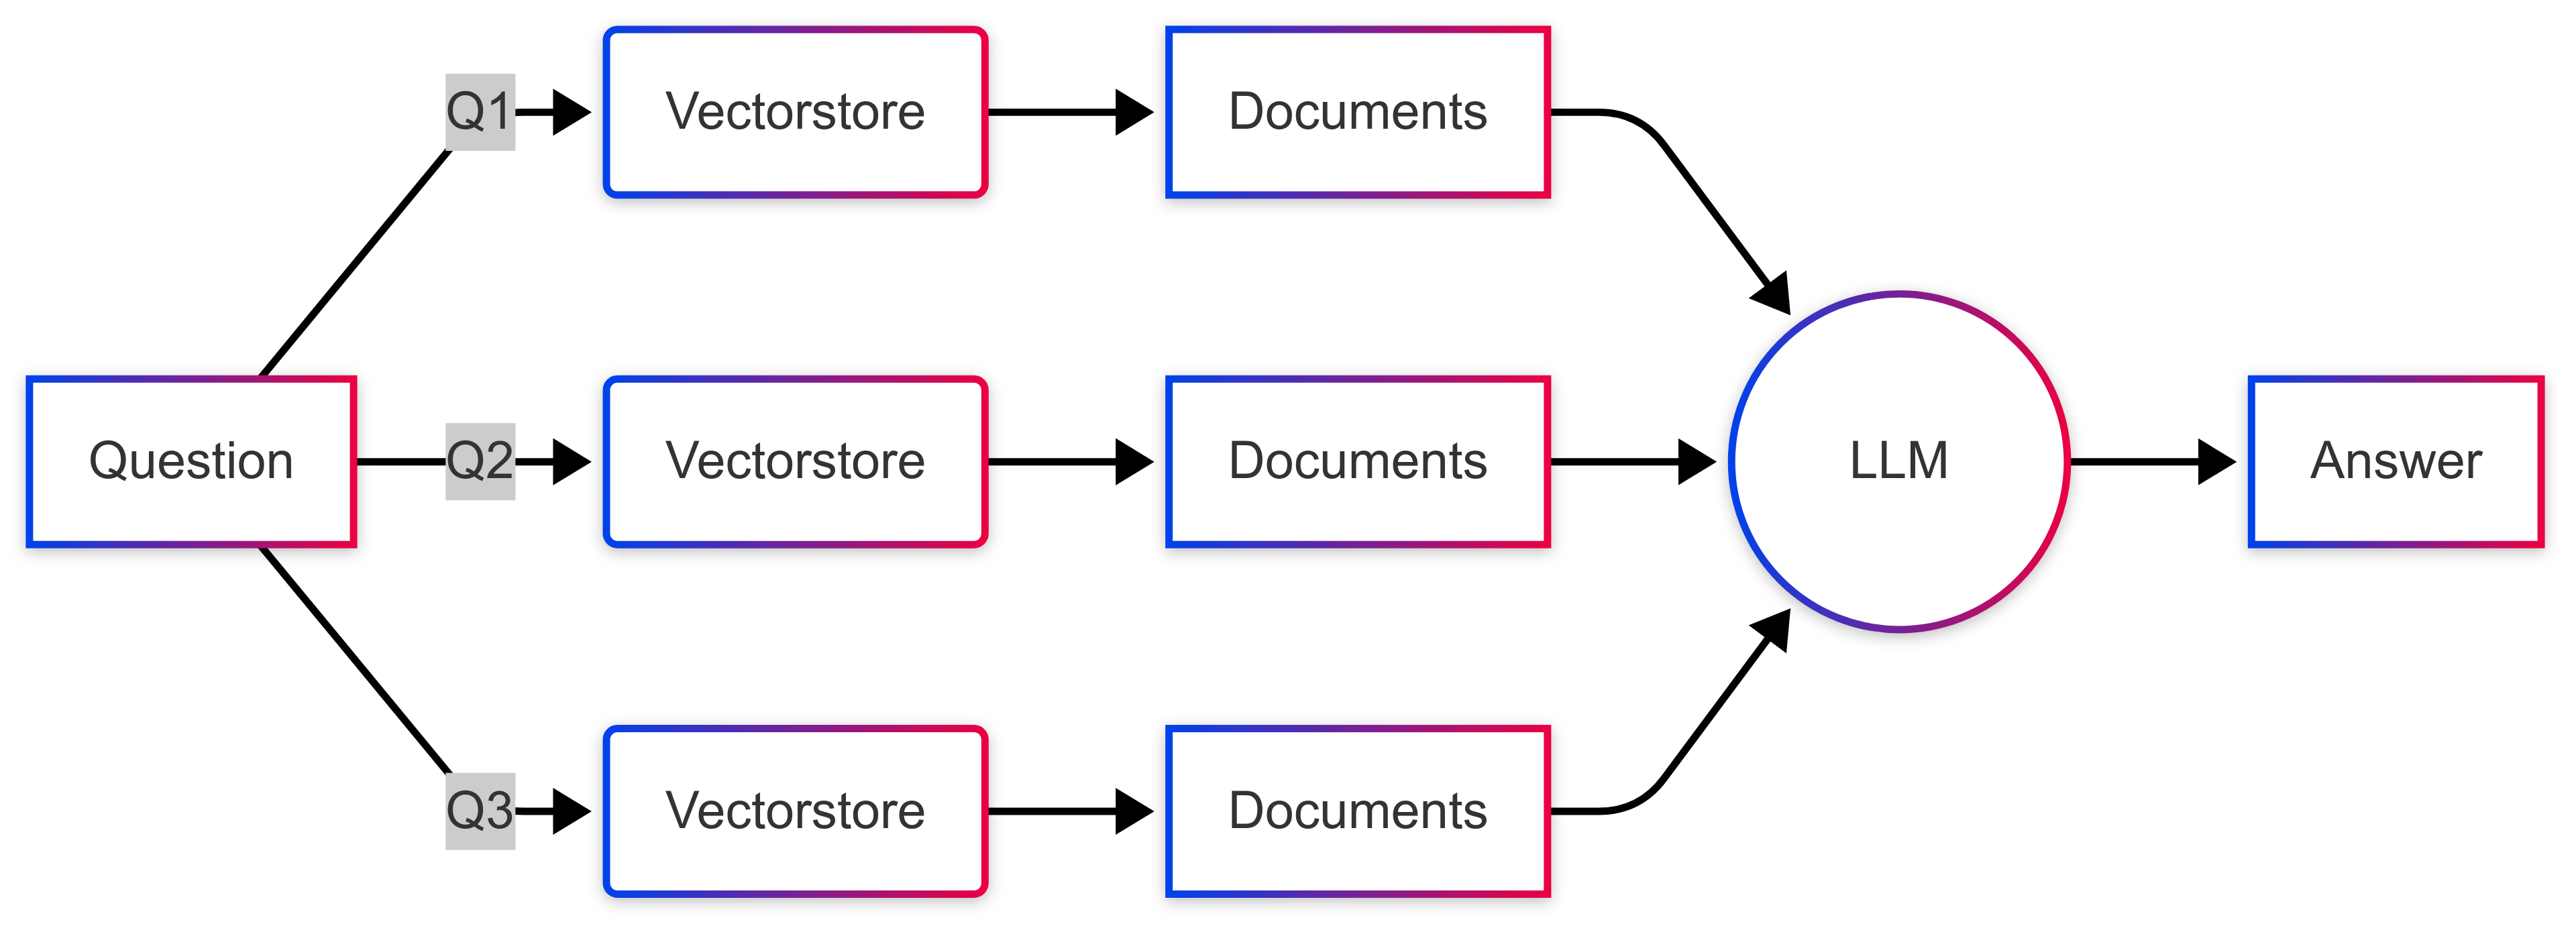

## üèóÔ∏è Organisation du pipeline
Ce pipeline est structur√© autour de plusieurs agents orchestr√©s dans un graphe LangGraph.

| √âtape                   | R√¥le                                                           |
| ----------------------- | -------------------------------------------------------------- |
| üì• `IngestionAgent`     | Charge et pr√©pare les documents sources                        |
| üîÅ `CheckCacheAgent`  | V√©rifie si la requ√™te est d√©j√† en cache (multiquery + r√©ponse) |
| üéØ `MultiQueryAgent`    | G√©n√®re des variations de la question avec un raisonnement      |
| üîç `RetrievalAgent`     | Cherche dans les documents √† l‚Äôaide de chaque variation        |
| üìù `RestitutionAgent`   | G√©n√®re une r√©ponse structur√©e √† partir du contexte             |
| üß† `ReturnCachedAnswer` | Retourne directement la r√©ponse si elle est d√©j√† en cache      |
| üí¨ `AskFeedbackAgent`   | Demande un retour utilisateur sur la r√©ponse                   |
| üîÑ `FeedbackAgent`      | Relance le pipeline si le feedback sugg√®re une am√©lioration    |


## üìå Structure du Code
Le pipeline est construit sous la forme d'un graphe d'agents, avec un flux enrichi :

    ‚ûú ingestion
          ‚Üì
    ‚ûú check_cache
        ‚îú‚îÄ(hit)‚îÄ‚îÄ> return_cached_answer
        ‚îî‚îÄ(miss)‚îÄ> multiquery
                        ‚Üì
                  retrieval
                        ‚Üì
                  restitution
                        ‚Üì
                ask_feedback
                        ‚Üì
                    feedback


‚öôÔ∏è En cas de feedback utile, le pipeline reboucle depuis retrieval.


## üîç Sorties Structur√©es
Le pipeline utilise trois classes Pydantic principales :

MultiQueryOutput
```python
class MultiQueryOutput(BaseModel):
    queries: List[str]      # Liste des variations de requ√™tes
    reasoning: str          # Explication du raisonnement
```

ScoredQuery
```python
class ScoredQuery(BaseModel):
    query: str
    score: float  # entre 0.0 et 1.0
```

ResponseFormatter
```python
class ResponseFormatter(BaseModel):
    answer: str            # R√©ponse finale
    sources: List[str]     # Sources utilis√©es
```

RAGState
```python
class RAGState(BaseModel):
    query: str
    sources: List[Dict[str, str]]
    available_docs: int = 0
    ingested: Optional[List[Document]] = None
    retrieved_docs: Optional[List[str]] = None
    multiple_queries: Optional[MultiQueryOutput] = None
    answer: Optional[ResponseFormatter] = None
    feedback_input: Optional[str] = None
    should_continue: bool = False
    cache_hit: Optional[bool] = None
```


## ‚ö° Avantages du MultiQuery

| Avantage                     | Description                                                              |
| ---------------------------- | ------------------------------------------------------------------------ |
| üìö **Couverture accrue**     | Capture diff√©rentes interpr√©tations de la requ√™te originale              |
| üõ°Ô∏è **Robustesse**           | R√©duit la d√©pendance √† une formulation unique                            |
| üîé **Transparence**          | Chaque requ√™te est accompagn√©e d‚Äôun score et d‚Äôun raisonnement explicite |
| üß™ **Validation structur√©e** | Les √©tapes reposent sur des sch√©mas Pydantic solides                     |
| üöÄ **Performance**           | Le cache permet des r√©ponses instantan√©es pour les questions fr√©quentes  |


## ‚ö†Ô∏è Inconv√©nients & Prochaines √©tapes

| Limite                       | Cons√©quence                        | Am√©lioration au niveau 3                      |
| ---------------------------- | ---------------------------------- | --------------------------------------------- |
| Cache local uniquement       | Non partag√© entre instances        | Redis, base distribu√©e                        |
| VectorStore en m√©moire       | Pas persistant, pas optimis√©       | Index FAISS local & persistant                |
| Recherche na√Øve              | Recherche par similarit√© simple    | Fusion des r√©sultats avec RRF                 |
| Pas d‚Äôaiguillage intelligent | Le flux va toujours vers ingestion | Agent d'initialisation pour routage dynamique |



## R√©alisation

In [ ]:
from typing import List, Optional
from pydantic import BaseModel, Field
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnablePassthrough
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph
from operator import itemgetter
from langchain.load import dumps, loads
from functools import lru_cache
from diskcache import Cache

multiquery_cache = Cache("./multiquery_cache")
response_cache = Cache("./response_cache")

In [ ]:
class ScoredQuery(BaseModel):
    query: str
    score: float = Field(
        ge=0.0, le=1.0,
        description="A relevance score between 0 (bad) and 1 (very relevant)"
    )

class MultiQueryOutput(BaseModel):
    queries: List[ScoredQuery] = Field(
        description="List of alternative queries generated from the original question, each with a relevance score",
        min_items=1,
        max_items=5
    )
    reasoning: str = Field(
        description="Explanation of how the alternative queries were generated and scored"
    )

class ResponseFormatter(BaseModel):
    answer: str = Field(description="The response to the user's question.")
    sources: List[str] = Field(description="The sources used to generate the answer.")


# Enhanced state definition
class RAGState(BaseModel):
    query: str
    sources: List[Dict[str, str]]
    available_docs: int = 0
    ingested: Optional[List[Document]] = None
    retrieved_docs: Optional[List[str]] = None
    multiple_queries: Optional[MultiQueryOutput] = None
    answer: Optional[ResponseFormatter] = None
    feedback_input: Optional[str] = None
    should_continue: bool = False
    cache_hit: Optional[bool] = None

In [ ]:
def cached_multiquery(question: str) -> MultiQueryOutput:
    template = """
    You are an expert AI assistant. Your task is to:
    1. Generate 3 to 5 variations of the user's original question
    2. Each variation should reflect a distinct interpretation or emphasis
    3. Score each variation from 0.0 (not useful) to 1.0 (very relevant), based on clarity, novelty, and coverage of the original intent
    4. Explain your reasoning for the scoring

    Original question: {question}

    Return a structured response with:
    - queries: a list of {{ "query": ..., "score": ... }}
    - reasoning: your explanation of how you generated and scored the variations
    """
    target_llm = get_chat_model({
        "configurable": {
            "model_type": "openai",
            "model": "gpt-4o-mini",
            "temperature": 0,
            "max_retry": 2
        }
    })
    prompt = ChatPromptTemplate.from_template(template)
    structured_llm = target_llm.with_structured_output(MultiQueryOutput, method="function_calling")
    chain = prompt | structured_llm

    return chain.invoke({"question": question})


In [ ]:
def check_cache_agent(state: RAGState) -> RAGState:
    cached = multiquery_cache.get(state.query)
    if cached:
        return {
            "multiple_queries": cached,
            "cache_hit": True
        }
    return {"cache_hit": False}

def return_cached_answer(state: RAGState) -> RAGState:
    answer = response_cache.get(state.query)
    if not answer:
        raise ValueError("‚ùå Cache inconsistant : r√©ponse absente malgr√© cache_hit=True")

    print(f"‚úÖ Returning cached answer for query: {state.query}")
    return {
        "answer": answer
    }

In [ ]:
# Multiquery generation agent with structured output
def multiquery_agent(state: RAGState) -> RAGState:
    result = cached_multiquery(state.query)
    multiquery_cache[state.query] = result
    return {"multiple_queries": result}

In [ ]:
def get_unique_union(documents: list[list]) -> List[Document]:
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    unique_docs = list(set(flattened_docs))
    return [loads(doc) for doc in unique_docs]


# Modified retrieval agent to use structured multiquery output
def retrieval_agent(state: RAGState) -> RAGState:
    if not state.available_docs > 0:
        raise ValueError("No documents indexed!")

    target_embedding = get_embeddings({
        "configurable": {
            "embedding_type": "openai",
            "embedding_model": "text-embedding-3-small"
        }
    })

    vectorstore = Chroma.from_documents(documents=state.ingested, embedding=target_embedding)
    retriever = vectorstore.as_retriever()

    # Retrieve documents for each query
    all_docs = []
    for query in state.multiple_queries.queries:  # Now accessing the structured output
        docs = retriever.invoke(query.query)
        all_docs.append(docs)

    # Get unique documents
    unique_docs = get_unique_union(all_docs)
    formatted_docs = "\n\n".join(doc.page_content for doc in unique_docs)

    return {"retrieved_docs": [formatted_docs]}

In [ ]:
# Restitution agent remains the same
def restitution_agent(state: RAGState) -> RAGState:
    if not state.retrieved_docs:
        raise ValueError("No documents retrieved!")

    prompt_template = ChatPromptTemplate.from_template("""
    Answer the question using only the following context:
    {context}

    Question: {question}

    Return your response in a structured format with the answer and the sources used.
    """)

    target_llm = get_chat_model({
        "configurable": {
            "model_type": "openai",
            "model": "gpt-4o-mini",
            "temperature": 0,
            "max_retry": 2
        }
    })

    structured_llm = target_llm.with_structured_output(ResponseFormatter, method="function_calling")
    chain = prompt_template | structured_llm

    response = chain.invoke({
        "context": state.retrieved_docs[0],
        "question": state.query
    })

    response_cache[state.query] = response
    return {"answer": response}

In [ ]:
#### üíö Agent de Feedback ####
client = Client()

def feedback_agent(state: RAGState) -> RAGState:
    feedback = state.feedback_input.lower()

    # Si feedback utile, modifier la requ√™te
    if any(word in feedback for word in ["pas clair", "exemple", "vague", "mauvais", "recommence", "pr√©cis"]):
        print(state.query)
        new_query = f"{state.query} (Am√©liore avec des exemples et plus de clart√©, l'utilisateur a dit: '{feedback}')"
        return {
            "query": new_query,
            "should_continue": True,
            "feedback_input": None  # reset
        }

    # Feedback pas utile ou non pertinent
    return {
        "should_continue": False,
        "feedback_input": None
    }




def ask_feedback_agent(state: RAGState) -> RAGState:
    print("üí¨ R√©ponse :", state.answer)
    user_feedback = input("üìù Entrez un feedback (ou laissez vide pour continuer) : ").strip()

    return {
        "feedback_input": user_feedback,
        "should_continue": bool(user_feedback)
    }

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [ ]:
# Build the graph
graph = StateGraph(RAGState)

# Add nodes
graph.add_node("ingestion", ingestion_agent)
graph.add_node("check_cache", check_cache_agent)
graph.add_node("multiquery", multiquery_agent)
graph.add_node("retrieval", retrieval_agent)
graph.add_node("restitution", restitution_agent)
graph.add_node("return_cached_answer", return_cached_answer)
graph.add_node("ask_feedback", ask_feedback_agent)
graph.add_node("feedback", feedback_agent)

# Connect the steps
graph.set_entry_point("ingestion")
graph.add_edge("ingestion", "check_cache")
# If the request is stored in cache, we given pregenerated response, else, we give the request to multiquery
graph.add_conditional_edges("check_cache", lambda state:
    "return_cached_answer" if state.cache_hit else "multiquery"
)
graph.add_edge("multiquery", "retrieval")
graph.add_edge("retrieval", "restitution")
graph.add_edge("restitution", "ask_feedback")
graph.add_edge("return_cached_answer", "ask_feedback")
graph.add_edge("ask_feedback", "feedback")

# Conditionnelle : soit on relance, soit on termine
graph.add_conditional_edges("feedback", lambda state: "retrieval" if state.should_continue else "end")


# Compile the pipeline
executor = graph.compile()

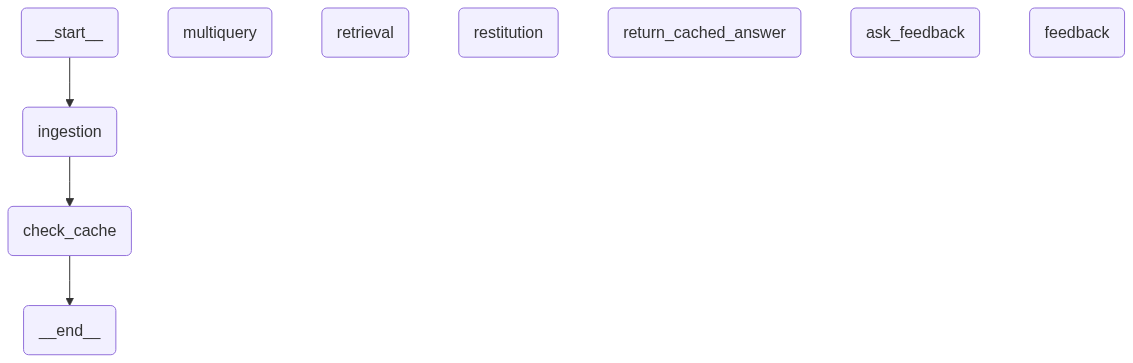

In [ ]:
from IPython.display import Image, display
display(Image(executor.get_graph().draw_mermaid_png()))

In [ ]:
query = "Comment implementer un tool in LangChain in python?"
source = {"type": "web", "path": "https://langchain-ai.github.io/langgraph/tutorials/get-started/2-add-tools/#add-tools"}

result = executor.invoke(RAGState(query=query, sources=[source]))

if(result['cache_hit'] == True) :
  display("üîÅ The query was stored in cache üîÅ")
else:
  display("üí¨ Generated Queries:", result['multiple_queries'].queries)
  display("ü§î Query Generation Reasoning:", result['multiple_queries'].reasoning)

print("üìù Final Answer:", result['answer'].answer)

‚úÖ Returning cached answer for query: Comment implementer un tool in LangChain in python?
üí¨ R√©ponse : answer="Pour impl√©menter un outil (tool) dans LangChain en Python, vous devez suivre ces √©tapes g√©n√©rales :\n\n1. **D√©finir l'outil** : Cr√©ez une classe ou une fonction qui repr√©sente l'outil que vous souhaitez ajouter. Cela peut inclure des m√©thodes pour ex√©cuter des actions sp√©cifiques.\n\n2. **Enregistrer l'outil** : Utilisez les m√©canismes fournis par LangChain pour enregistrer votre outil dans le syst√®me. Cela peut impliquer d'ajouter votre outil √† une liste d'outils disponibles ou de l'int√©grer dans un agent ou une cha√Æne.\n\n3. **Utiliser l'outil** : Une fois l'outil enregistr√©, vous pouvez l'utiliser dans vos agents ou cha√Ænes pour effectuer des t√¢ches sp√©cifiques en r√©ponse aux demandes des utilisateurs.\n\n4. **Tester l'outil** : Assurez-vous de tester l'outil pour v√©rifier qu'il fonctionne comme pr√©vu dans le contexte de votre application.\n\nCes √

'üîÅ The query was stored in cache üîÅ'

üìù Final Answer: Pour impl√©menter un outil (tool) dans LangChain en Python, vous devez suivre ces √©tapes g√©n√©rales :

1. **D√©finir l'outil** : Cr√©ez une classe ou une fonction qui repr√©sente l'outil que vous souhaitez ajouter. Cela peut inclure des m√©thodes pour ex√©cuter des actions sp√©cifiques.

2. **Enregistrer l'outil** : Utilisez les m√©canismes fournis par LangChain pour enregistrer votre outil dans le syst√®me. Cela peut impliquer d'ajouter votre outil √† une liste d'outils disponibles ou de l'int√©grer dans un agent ou une cha√Æne.

3. **Utiliser l'outil** : Une fois l'outil enregistr√©, vous pouvez l'utiliser dans vos agents ou cha√Ænes pour effectuer des t√¢ches sp√©cifiques en r√©ponse aux demandes des utilisateurs.

4. **Tester l'outil** : Assurez-vous de tester l'outil pour v√©rifier qu'il fonctionne comme pr√©vu dans le contexte de votre application.

Ces √©tapes peuvent varier l√©g√®rement en fonction de la version de LangChain que vous utilisez et des sp√©cif

# RAG level 3 avec FAISS, stored index, configurable

Cette nouvelle version introduit notamment un initializer_agent pour d√©terminer dynamiquement le chemin √† suivre (ingestion ou multiquery) et inclut des modifications dans la gestion des sources, l‚Äôindexation FAISS et la restitution.


## üèóÔ∏è Organisation du pipeline
Ce pipeline RAG est d√©sormais structur√© autour de cinq agents :

* üèÅ initializer_agent
  * V√©rifie l'existence d'un index FAISS local.
  * Oriente le flux vers l'agent d‚Äôingestion ou directement vers l‚Äôagent multiquery.
* üì• ingestion_agent
* üéØ multiquery_agent
* üîç retrieval_agent
  * Cr√©e ou recharge un index FAISS local (avec OllamaEmbeddings).
  * Effectue une recherche par similarit√© et consolide les r√©sultats (d√©doublonnage).
  * Retourne la liste des documents pertinents.
* üìù restitution_agent

##üîÑ Am√©lioration du Retrieval avec RRF (Reciprocal Rank Fusion)
Le retrieval_agent a √©t√© optimis√© pour int√©grer le Reciprocal Rank Fusion, une m√©thode sophistiqu√©e de fusion des r√©sultats de recherche.

#### Pourquoi RRF ?
* ‚úÖ Fusion intelligente : Combine les r√©sultats de plusieurs requ√™tes en une seule liste ordonn√©e
* ‚úÖ Robustesse : R√©duit l'impact des r√©sultats aberrants et favorise les documents pertinents r√©currents
* ‚úÖ Pas de normalisation : Fonctionne directement sur les rangs, sans n√©cessiter de normalisation des scores


#### Fonctionnement du RRF
1. **Collecte des r√©sultats**

```python
# Pour chaque variante de requ√™te g√©n√©r√©e par multiquery_agent
query_results = []
for query in queries:
    docs = vectorstore.similarity_search(query, k=10)
    query_results.append(docs)
```

2. **Calcul des scores RRF**

```python
RRF_score(document) = Œ£ 1/(rang + k)
```

 * o√π :

  * rang est la position du document dans chaque liste de r√©sultats
  * k est une constante (60 par d√©faut) qui att√©nue l'impact des rangs √©lev√©s

3. **Exemple de scoring Si un document appara√Æt aux positions :**

  * Rang 1 dans Query 1 : 1/(1 + 60) = 0.0164
  * Rang 3 dans Query 2 : 1/(3 + 60) = 0.0159
  * Rang 5 dans Query 3 : 1/(5 + 60) = 0.0154 Son score RRF final sera : 0.0477

#### Impact sur le pipeline

* Simplification : Fusion de la r√©cup√©ration et du r√©-ordonnancement en une seule √©tape
* Performance : R√©duction du nombre d'op√©rations sur le vectorstore
* Qualit√© : Meilleure pertinence des r√©sultats gr√¢ce √† la prise en compte de multiples perspectives de recherche

In [ ]:
from typing import List, Optional, Dict, Literal, Any
from pydantic import BaseModel, Field
from operator import itemgetter

from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader

from langchain_community.vectorstores import Chroma
from langchain_community.vectorstores import FAISS

from langchain_core.runnables.config import RunnableConfig
from langchain_core.runnables import RunnablePassthrough
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents import Document

from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END, START
from langchain.load import dumps, loads

In [ ]:
# Structured Output Models
class DocumentMetadata(BaseModel):
    source_url: str
    chunk_id: int


class MultiQueryOutput(BaseModel):
    queries: List[str] = Field(
        description="List of alternative queries generated from the original question",
        min_items=1,
        max_items=5
    )
    reasoning: str = Field(
        description="Explanation of how the alternative queries were relevant to expand the search space for the user query"
    )


class ResponseFormatter(BaseModel):
    answer: str = Field(description="The response to the user's question.")


class ResponseOutput(BaseModel):
    answer: str = Field(description="The response to the user's question.")
    sources: List[DocumentMetadata] = Field(description="The metadata of sources used to generate the answer.")

In [ ]:
# State Management
class RAGState(BaseModel):
    query: str
    sources: Dict[str, Any] = None
    available_docs: int = 0
    ingested: Optional[List[Document]] = None
    retrieved_docs: Optional[List[Document]] = None
    multiple_queries: Optional[MultiQueryOutput] = None
    answer: Optional[ResponseOutput] = None

In [ ]:
# Source Loader Factory
class SourceLoader:
    @staticmethod
    def get_loader(source_type: str, location: str):
        loaders = {
            "web": lambda loc: WebBaseLoader(web_paths=[loc]),
            "pdf": lambda loc: PyPDFLoader(loc),
        }

        loader = loaders.get(source_type.lower())
        if not loader:
            raise ValueError(f"Unsupported source type: {source_type}")

        return loader(location)

In [ ]:
def get_vector_store(config, target_embedding, index_name, state):
    """
    Retrieves or builds a FAISS vector store based on the provided configuration.

    Args:
        config (dict): Configuration dictionary containing the path to the stored index.
        target_embedding: Embedding function or model.
        index_name (str): The name of the index.
        state: An object containing the ingested documents if the index needs to be rebuilt.

    Returns:
        FAISS: The FAISS vector store instance.
    """
    stored_index_base = config["configurable"].get("stored_index")
    stored_index_type = config["configurable"].get("embedding_type")
    stored_index_model = config["configurable"].get("embedding_model")

    # La base vectorielle change avec le mod√®le de embedding (la dimensionnalit√© et le typage pourraient changer)
    stored_index_path = f"{stored_index_base}.{stored_index_type}.{stored_index_model}"

    try:
        vectorstore = FAISS.load_local(
            folder_path=stored_index_path,
            embeddings=target_embedding,
            index_name=index_name,
            allow_dangerous_deserialization=True
        )
        print("‚úÖ Data index loaded from cache!")
    except Exception as e:
        print(f"‚ö†Ô∏è Failed to load index from cache.")
        print("üîÑ Building the index from documents...")

        vectorstore = FAISS.from_documents(
            documents=state.ingested,
            embedding=target_embedding
        )

        vectorstore.save_local(stored_index_path, index_name=index_name)
        print("üíæ Index saved locally!")

    return vectorstore

In [ ]:
def initializer_agent(state: RAGState, config: RunnableConfig) -> Literal["ingestion", "multiquery"]:
    """
    Determines the flow based on whether documents need to be loaded
    and if FAISS index exists
    """
    faiss_index_path = config["configurable"].get("stored_index")
    faiss_index_exists = os.path.exists(faiss_index_path)

    if not faiss_index_exists:
        return "ingestion"
    else:
        return "multiquery"

In [ ]:
def ingestion_agent(state: RAGState, config: RunnableConfig):
    """
    Handles document ingestion from multiple sources with proper document splitting
    and metadata preservation.
    """
    all_docs = []
    total_docs = 0
    global_chunk_id = 0

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=config["configurable"].get("chunk_size", 500),
        chunk_overlap=config["configurable"].get("chunk_overlap", 100)
    )

    for source_type, source_locations in state.sources.items():
        if isinstance(source_locations, str):
            source_locations = [source_locations]

        for location in source_locations:
            try:
                loader = SourceLoader.get_loader(source_type, location)
                docs = loader.load()

                for doc in docs:
                    if not hasattr(doc, 'metadata'):
                        doc.metadata = {}

                    original_metadata = {
                        "source_url": location
                    }

                    splits = text_splitter.split_text(doc.page_content)

                    for split_text in splits:
                        split_doc = Document(
                            page_content=split_text,
                            metadata={
                                **original_metadata,
                                "chunk_id": global_chunk_id
                            }
                        )
                        all_docs.append(split_doc)
                        global_chunk_id += 1
                        total_docs += 1

            except Exception as e:
                continue

    if not all_docs:
        raise ValueError("No documents were successfully loaded")

    return {
        "available_docs": total_docs,
        "ingested": all_docs
    }

In [ ]:
def multiquery_agent(state: RAGState, config: RunnableConfig):
    """
    Generates multiple query variations using structured output.
    """
    template = """You are an AI language model assistant. Your task is to:
    1. Generate between 3-5 different versions of the given user question
    2. Each version should provide a different perspective or approach to the original question
    3. Explain your reasoning for generating these specific variations

    Original question: {question}

    Provide your response in a structured format with:
    - A list of alternative queries
    - Your reasoning for generating these specific variations
    """

    target_llm = get_chat_model(config)

    # Initialize LLM and embeddings
    target_llm = get_chat_model(config)

    prompt = ChatPromptTemplate.from_template(template)
    structured_llm = target_llm.with_structured_output(MultiQueryOutput, method="function_calling")
    chain = prompt | structured_llm

    result = chain.invoke({
        "question": state.query
    })
    return {"multiple_queries": result}

In [ ]:
def retrieval_agent(state: RAGState, config: RunnableConfig):
    """
    Retrieves relevant documents using FAISS with persistence.
    """

    # Create or load FAISS index
    target_embedding = get_embeddings(config)
    index_name = "docs_index"
    vectorstore = get_vector_store(config, target_embedding, index_name, state)

    # It√©rer sur toutes les requ√™tes g√©n√©r√©es + la query originale
    all_queries = [state.query] + state.multiple_queries.queries

    retrieved_docs = []
    seen_keys = set()

    for query in all_queries:
        docs = vectorstore.max_marginal_relevance_search(
            query=query,
            k=len(all_queries),
            fetch_k=2 * len(all_queries)
        )

        for doc in docs:
            key = (doc.page_content, doc.metadata.get('chunk_id'))
            if key not in seen_keys:
                retrieved_docs.append(doc)
                seen_keys.add(key)

    return {"retrieved_docs": retrieved_docs}

In [ ]:
def restitution_agent(state: RAGState, config: RunnableConfig):
    """
    Generates final response with source attribution.
    """
    if not state.retrieved_docs:
        raise ValueError("No retrieved documents to generate response from")

    # Prepare context from retrieved documents
    context = "\n\n".join(doc.page_content for doc in state.retrieved_docs)

    # Generate the response using the LLM
    target_llm = get_chat_model(config)
    response = target_llm.invoke(
        f"""Based on the following context, answer the question: ```{state.query}```

        Context: ```
{context}
        ```

        Provide a clear and direct answer."""
    )

    # Extract source metadata
    sources = [
        DocumentMetadata(
            source_url=doc.metadata.get("source_url", ""),
            chunk_id=doc.metadata.get("chunk_id", 0)
        )
        for doc in state.retrieved_docs
    ]

    # Format the response
    formatted_response = ResponseOutput(
        answer=response.content,
        sources=sources
    )

    return {"answer": formatted_response}

In [ ]:
# Graph Construction
"""
Constructs and returns the RAG processing graph.
"""
graph = StateGraph(RAGState)

# Add nodes
graph.add_node("ingestion", ingestion_agent)
graph.add_node("multiquery", multiquery_agent)
graph.add_node("retrieval", retrieval_agent)
graph.add_node("restitution", restitution_agent)

# Connect nodes
graph.add_conditional_edges(
    START,
    initializer_agent
)
# graph.set_entry_point("ingestion")
graph.add_edge("ingestion", "multiquery")
graph.add_edge("multiquery", "retrieval")
graph.add_edge("retrieval", "restitution")
graph.add_edge("restitution", END)

from langgraph.graph.state import CompiledStateGraph
executor = graph.compile()

In [ ]:
from IPython.display import Image, display
display(Image(executor.get_graph().draw_mermaid_png()))

In [ ]:
def process_query(query: str, sources: Dict[str, Any], config: Any):
    """
    Processes a query using the RAG system.
    """
    result = executor.invoke(RAGState(query=query, sources=sources), config=config)

    # Format and return results
    return {
        "answer": result['answer'].answer,
        "sources": set(source.source_url for source in result['answer'].sources),
    }

In [ ]:
sources = {
    "web": [
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/00-introduction.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/01-develoment.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/02-lang-family.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/03-explain-langgraph.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/04-explain-langchain.md",
    ]
}
query = "C'est quoi et comment fonctionne un VectorStore en LangChain?"
config = {
    "configurable": {
        "max_contexts": 3,
        "model_type": "ollama",
        "model": "llama3.2",
        "temperature": 0.3,
        "embedding_type": "ollama",
        "embedding_model": "nomic-embed-text",
        "stored_index": "./faiss_index_rag3",
        "chunk_size": 500,
        "chunk_overlap": 100
    }
}

result = process_query(query, sources, config)
print("üí¨ Answer:", result['answer'])
print("\n\nüìö Sources Used:")
for source in result['sources']:
    print(f"- {source}")

# RAG level 4 avec Reciprocal Rank Fusion


## üîÑ Am√©lioration du Retrieval avec RRF (Reciprocal Rank Fusion)
Le retrieval_agent a √©t√© optimis√© pour int√©grer le Reciprocal Rank Fusion, une m√©thode sophistiqu√©e de fusion des r√©sultats de recherche.

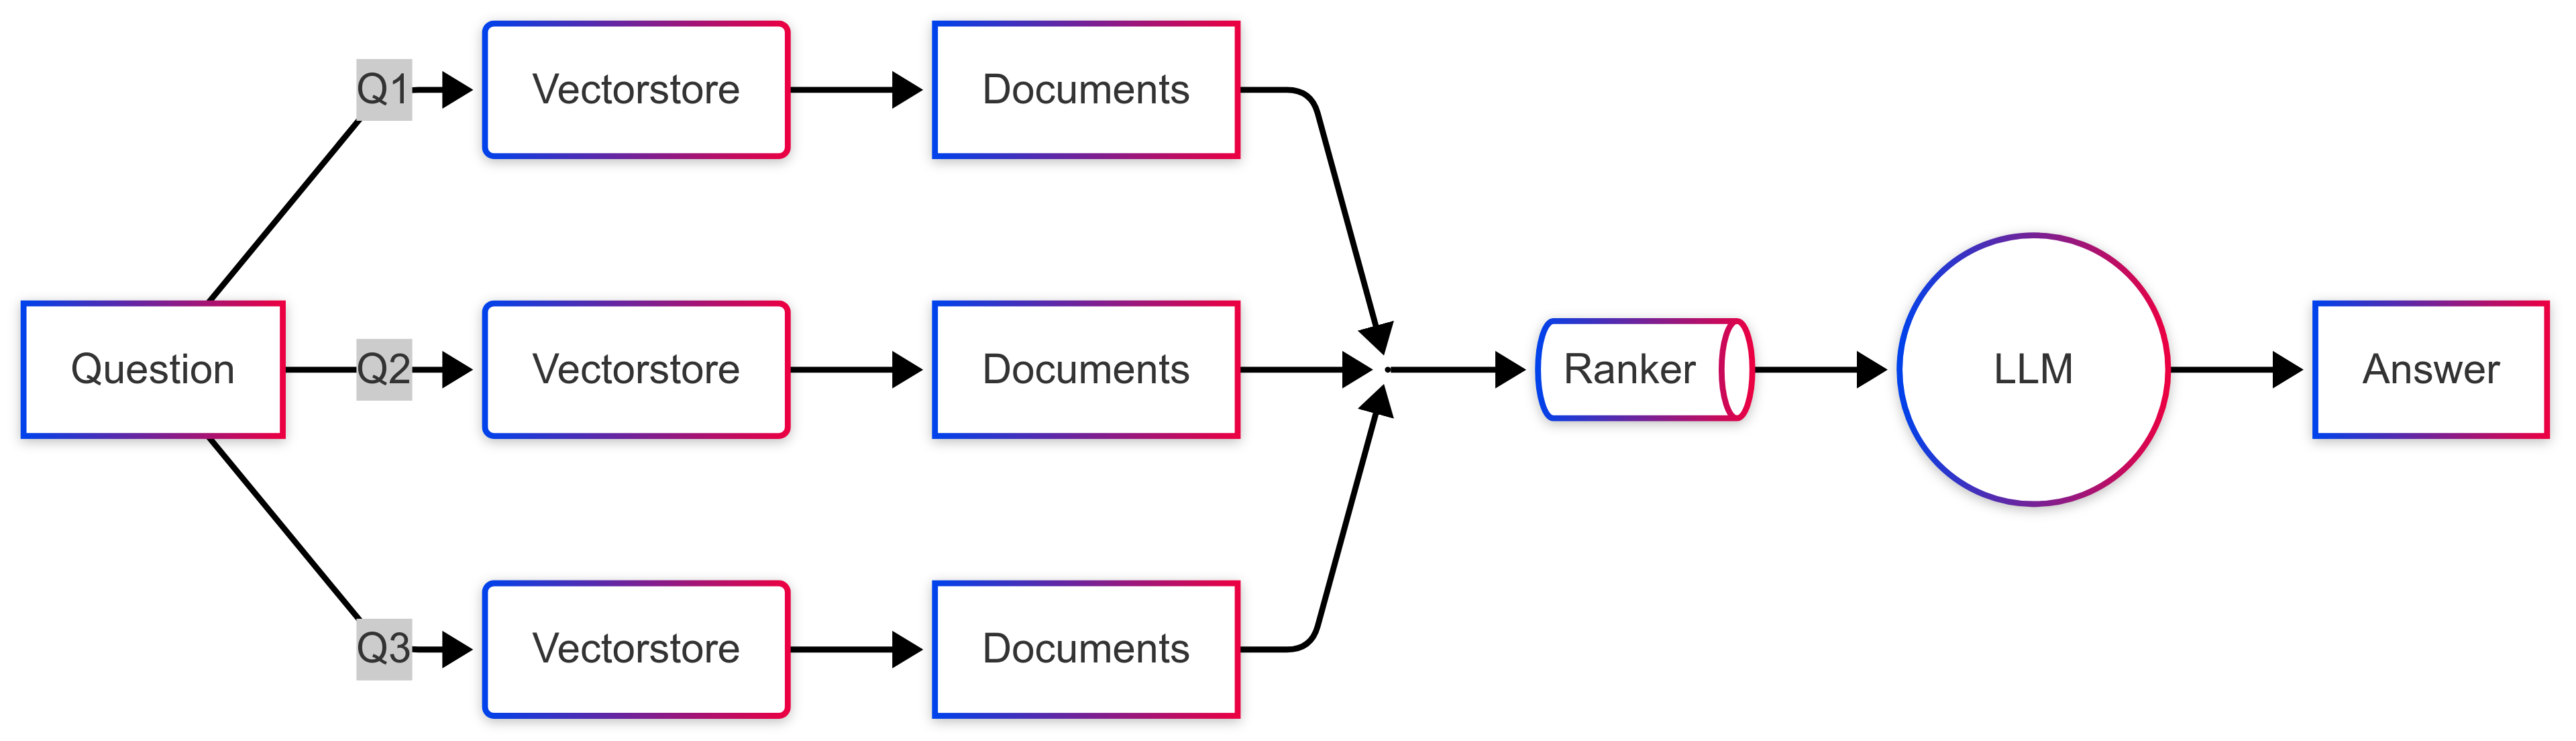


Pourquoi RRF ?
* ‚úÖ Fusion intelligente : Combine les r√©sultats de plusieurs requ√™tes en une seule liste ordonn√©e
* ‚úÖ Robustesse : R√©duit l'impact des r√©sultats aberrants et favorise les documents pertinents r√©currents
* ‚úÖ Pas de normalisation : Fonctionne directement sur les rangs, sans n√©cessiter de normalisation des scores

## Fonctionnement du RRF

1. Collecte des r√©sultats

```
# Pour chaque variante de requ√™te g√©n√©r√©e par multiquery_agent
query_results = []
for query in queries:
    docs = vectorstore.similarity_search(query, k=10)
    query_results.append(docs)
```

2. Calcul des scores RRF

RRF_score(document) = Œ£ 1/(rang + k)
o√π:

* rang est la position du document dans chaque liste de r√©sultats
* k est une constante (60 par d√©faut) qui att√©nue l'impact des rangs √©lev√©s

3. Exemple de scoring Si un document appara√Æt aux positions :

* Rang 1 dans Query 1 : 1/(1 + 60) = 0.0164
* Rang 3 dans Query 2 : 1/(3 + 60) = 0.0159
* Rang 5 dans Query 3 : 1/(5 + 60) = 0.0154 Son score RRF final sera : 0.0477

## Impact sur le pipeline
* Simplification : Fusion de la r√©cup√©ration et du r√©-ordonnancement en une seule √©tape
* Performance : R√©duction du nombre d'op√©rations sur le vectorstore
* Qualit√© : Meilleure pertinence des r√©sultats gr√¢ce √† la prise en compte de multiples perspectives de recherche

In [ ]:
def retrieval_agent(state: RAGState, config: RunnableConfig):
    """
    Retrieves and ranks relevant documents using FAISS with RRF ranking.
    """
    # Create or load FAISS index
    target_embedding = get_embeddings(config)
    index_name = "docs_index"
    vectorstore = get_vector_store(config, target_embedding, index_name, state)

    # Step 1: Get initial results for each query variation
    # For each query, we get a ranked list of documents with similarity scores
    query_results = []
    print("\nStep 1: Initial retrieval for each query variant:")
    for i, query in enumerate(state.multiple_queries.queries):
        docs = vectorstore.similarity_search(query, k=config["configurable"].get("max_contexts", 5))
        query_results.append(docs)
        print(f"Query {i + 1}: '{query[:50]}...' retrieved {len(docs)} documents")

    # Step 2: Apply Reciprocal Rank Fusion
    # RRF score = sum across all rankings of 1/(rank + k)
    # where k is a constant that mitigates the impact of high rankings
    k = config["configurable"].get("rrf_k", 60)
    fused_scores = {}

    print("\nStep 2: RRF Scoring Details:")
    for query_index, docs in enumerate(query_results):
        print(f"\nProcessing results from Query {query_index + 1}:")

        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0

            # Calculate RRF score contribution for this document in this ranking
            rrf_contribution = 1 / (rank + k)
            fused_scores[doc_str] += rrf_contribution

            print(f"Document (chuck_id): '{doc.metadata.get('chunk_id')}'")
            print(f"  Rank in this query: {rank + 1}")
            print(f"  RRF score contribution: {rrf_contribution:.4f}")
            print(f"  Current total RRF score: {fused_scores[doc_str]:.4f}")

    # Step 3: Sort documents by their final RRF scores
    print("\nStep 3: Final Rankings:")
    sorted_docs = sorted(
        fused_scores.items(),
        key=itemgetter(1),
        reverse=True
    )

    # Print top 5 results with scores
    print("\nTop max_contexts (or 5) Documents after RRF:")
    for i, (doc_str, score) in enumerate(sorted_docs[:config["configurable"].get("max_contexts", 5)]):
        doc = loads(doc_str)
        print(f"{i + 1}. Score: {score:.4f} - '{doc.metadata.get('chunk_id')}...'")

    # Step 4: Create final retrieved_docs list with deduplication
    retrieved_docs = []
    seen_keys = set()

    for doc_str, _ in sorted_docs:
        doc = loads(doc_str)
        key = (doc.page_content, doc.metadata.get('chunk_id'))
        if key not in seen_keys:
            retrieved_docs.append(doc)
            seen_keys.add(key)

    print(f"\nFinal unique documents after deduplication: {len(retrieved_docs)}")
    return {"retrieved_docs": retrieved_docs}

In [ ]:
# Graph Construction
"""
Constructs and returns the RAG processing graph.
"""
graph = StateGraph(RAGState)

# Add nodes
graph.add_node("ingestion", ingestion_agent)
graph.add_node("multiquery", multiquery_agent)
graph.add_node("retrieval", retrieval_agent)
graph.add_node("restitution", restitution_agent)

# Connect nodes
graph.add_conditional_edges(
    START,
    initializer_agent
)
# graph.set_entry_point("ingestion")
graph.add_edge("ingestion", "multiquery")
graph.add_edge("multiquery", "retrieval")
graph.add_edge("retrieval", "restitution")
graph.add_edge("restitution", END)

from langgraph.graph.state import CompiledStateGraph
executor = graph.compile()

In [ ]:
def process_query(query: str, sources: Dict[str, Any], config: Any):
    """
    Processes a query using the RAG system.
    """
    result = executor.invoke(RAGState(query=query, sources=sources), config=config)

    # Format and return results
    return {
        "answer": result['answer'].answer,
        "sources": set(source.source_url for source in result['answer'].sources),
    }

In [ ]:
sources = {
    "web": [
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/00-introduction.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/01-develoment.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/02-lang-family.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/03-explain-langgraph.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/04-explain-langchain.md",
    ]
}
query = "C'est quoi et comment fonctionne un VectorStore en LangChain?"
config = {
    "configurable": {
        "max_contexts": 3,
        "model_type": "ollama",
        "model": "llama3.2",
        "temperature": 0.3,
        "embedding_type": "ollama",
        "embedding_model": "nomic-embed-text",
        "stored_index": "./faiss_index_rag3",
        "chunk_size": 500,
        "chunk_overlap": 100,
        "rrf_k": 60
    }
}

result = process_query(query, sources, config)
print("üí¨ Answer:", result['answer'])
print("\n\nüìö Sources Used:")
for source in result['sources']:
    print(f"- {source}")

# RAG level 5 avec Query Response Decomposition

L'architecture a √©t√© enrichie avec Query Response Decomposition (QRD), qui am√©liore la granularit√© et la pertinence des r√©ponses dans le pipeline RAG.

## üèó Introduction √† QRD
La d√©composition des requ√™tes permet de diviser une question complexe en sous-questions successives afin de mieux contextualiser et structurer la r√©ponse. Ce proc√©d√© am√©liore l‚Äôalignement entre la requ√™te et les r√©sultats du VectorStore, rendant la r√©cup√©ration d‚Äôinformations plus pr√©cise.

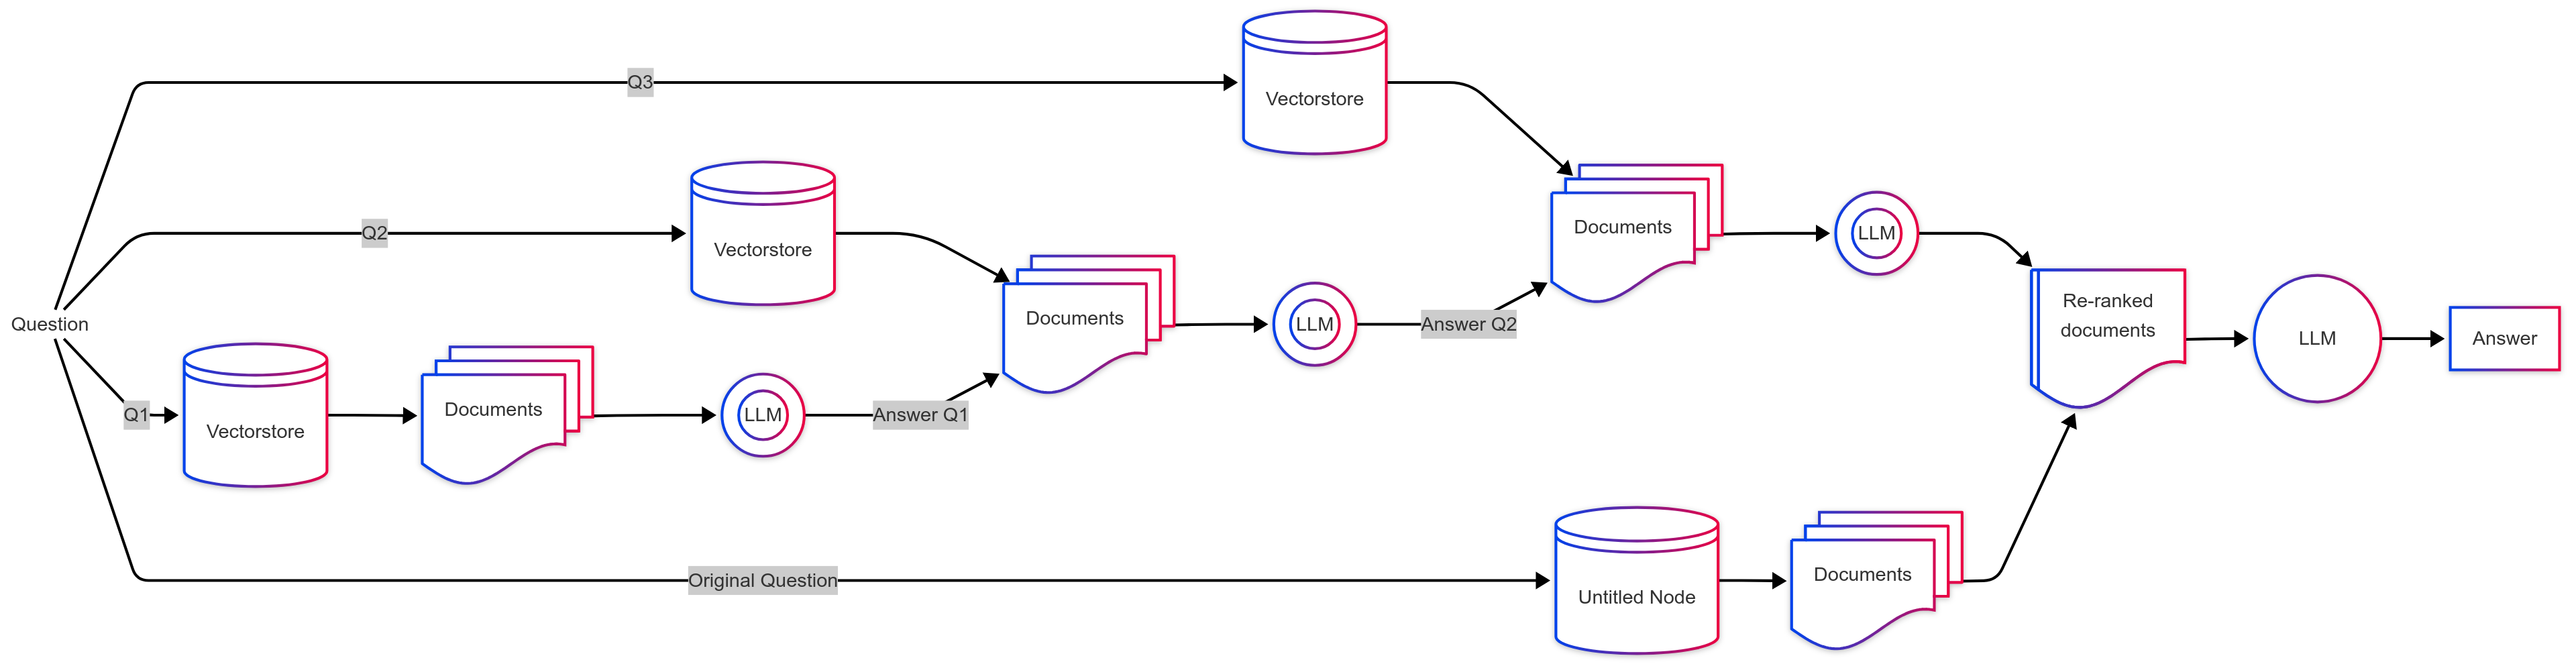

####üìå Graph de pipeline :

[Ingestion] ‚Üí [MultiQuery] ‚Üí [Decomposition] ‚Üí [Recursive Response] ‚Üí [Retrieval] ‚Üí [RRF Ranking] ‚Üí [Restitution]

####üí° Principales am√©liorations :

* D√©composition des questions en sous-questions progressives
* R√©ponses r√©cursives int√©grant les sous-questions pour enrichir la recherche
* Am√©lioration du retrieval avec des requ√™tes multi-niveaux bas√©es sur les r√©ponses interm√©diaires

## üîç 1. D√©composition des requ√™tes (Query Response Decomposition)
> Objectif : Transformer une question en une s√©quence logique de sous-questions autonomes pour am√©liorer le focus de chaque recherche.

###üìå Exemple de d√©composition :

üîπ Question originale :
üßê "Comment fonctionne LangChain pour la r√©cup√©ration d'informations dans une architecture RAG ?"

üîπ Sous-questions g√©n√©r√©es :
1Ô∏è‚É£ "Qu'est-ce que LangChain et quel est son r√¥le dans l'IA g√©n√©rative ?"
2Ô∏è‚É£ "Quels sont les principaux composants de LangChain utilis√©s pour la r√©cup√©ration d‚Äôinformations ?"
3Ô∏è‚É£ "Comment LangChain interagit-il avec un VectorStore pour r√©cup√©rer et traiter les documents ?"

## üèó 2. R√©ponses r√©cursives avec maintien du contexte
Une fois les sous-questions g√©n√©r√©es, le Recursive Response Agent les traite s√©quentiellement en maintenant l‚Äôhistorique conversationnel :

üîÑ Processus :
1Ô∏è‚É£ Extraction du contexte pour chaque sous-question
2Ô∏è‚É£ G√©n√©ration de r√©ponses interm√©diaires
3Ô∏è‚É£ Synth√®se finale en une r√©ponse compl√®te

## üìñ 3. Am√©lioration du Retrieval avec QRD & RRF
Le retrieval_agent est d√©sormais capable d'exploiter les sous-r√©ponses pour affiner la recherche d‚Äôinformations :

üí° M√©thodologie :

* üü¢ Recherche bas√©e sur la requ√™te principale
* üü¢ Recherche optimis√©e avec les sous-r√©ponses comme contexte suppl√©mentaire
* üü¢ Fusion RRF des r√©sultats pour ordonner les documents les plus pertinents

```python
# Recherche am√©lior√©e avec r√©ponses interm√©diaires
for sub_answer in recursive_result.sub_answers:
    enhanced_query = f"{sub_answer.question} {sub_answer.answer}"
    sub_docs = vectorstore.similarity_search(
        enhanced_query,
        k=config["configurable"].get("max_contexts", 3)
    )
    all_docs.extend(sub_docs)
```

##üèÜ 4. Restitution Finale : Synth√®se multi-niveau
Une fois les documents class√©s et fusionn√©s avec RRF, l‚Äôassistant restitue la r√©ponse finale en pr√©servant la structure conversationnelle :

#### üìå Format conversationnel structur√© :

```plaintext
üßë‚Äçüíª Human: "Comment fonctionne LangChain pour la r√©cup√©ration d'informations ?"
ü§ñ AI: "LangChain est une biblioth√®que permettant d'encha√Æner plusieurs √©tapes..."
üßë‚Äçüíª Human: "Quels sont les principaux composants de LangChain pour la r√©cup√©ration ?"
ü§ñ AI: "Les principaux composants sont les outils de gestion de la m√©moire..."
...
üßë‚Äçüíª Human: "Synth√©tisez la r√©ponse finale"
ü§ñ AI: "LangChain permet de r√©cup√©rer des documents en exploitant..."
```

## üî• Pourquoi cette approche ?
‚úÖ Granularit√© am√©lior√©e : La segmentation des requ√™tes √©vite les r√©ponses trop larges

‚úÖ Recherche plus pr√©cise : Chaque r√©ponse interm√©diaire optimise le retrieval suivant

‚úÖ Pipeline robuste & scalable : La modularit√© permet d‚Äôam√©liorer chaque √©tape ind√©pendamment

In [ ]:
import os
from operator import itemgetter
from typing import List, Optional, Dict, Literal, Any

from pydantic import BaseModel, Field
import bs4

# Set environment variable
os.environ["USER_AGENT"] = "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:123.0) Gecko/20100101 Firefox/123.0"

# LangChain Imports
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma, FAISS

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.retrievers import BaseRetriever
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables.config import RunnableConfig

from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import ChatPromptTemplate
from langchain.load import dumps, loads

from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# LangGraph Imports
from langgraph.graph import StateGraph, END, START

In [ ]:
class SubQuestionAnswer(BaseModel):
    question: str = Field(description="The sub-question")
    answer: str = Field(description="Answer to the sub-question")


class RecursiveAnswer(BaseModel):
    final_answer: str = Field(description="The synthesized answer incorporating all sub-question responses")


class RecursiveOutput(BaseModel):
    final_answer: str = Field(description="The synthesized answer incorporating all sub-question responses")
    sub_answers: List[SubQuestionAnswer] = Field(
        description="List of answers to each sub-question in sequential order"
    )


class DecompositionOutput(BaseModel):
    sub_questions: List[str] = Field(
        description="List of sub-questions generated from the original question",
        min_items=1,
        max_items=3
    )


class ResponseOutput(BaseModel):
    answer: str = Field(description="The final comprehensive answer")

In [ ]:
class MultiQueryOutput(BaseModel):
    queries: List[str] = Field(
        description="List of alternative queries generated from the original question",
        min_items=1,
        max_items=5
    )
    reasoning: str = Field(
        description="Explanation of how the alternative queries were relevant to expand the search space for the user query"
    )

In [ ]:
class RAGState(BaseModel):
    query: str
    sources: Dict[str, Any] = None
    available_docs: int = 0
    ingested: Optional[List[Document]] = None
    retrieved_docs: Optional[List[Document]] = None
    ranked_docs: Optional[List[Document]] = None  # New field for ranked documents
    multiple_queries: Optional[MultiQueryOutput] = None
    decomposed_results: Optional[Dict[str, DecompositionOutput]] = None
    recursive_answers: Optional[Dict[str, RecursiveOutput]] = None
    answer: Optional[ResponseOutput] = None

In [ ]:
def initializer_agent(state: RAGState, config: RunnableConfig) -> Literal["ingestion", "multiquery"]:
    """
    Determines the flow based on whether documents need to be loaded
    and if FAISS index exists
    """
    faiss_index_path = config["configurable"].get("stored_index")
    faiss_index_exists = os.path.exists(faiss_index_path)

    if not faiss_index_exists:
        return "ingestion"
    else:
        return "multiquery"

In [ ]:
def multiquery_agent(state: RAGState, config: RunnableConfig):
    """
    Generates multiple query variations using structured output.
    """
    template = """You are an AI language model assistant. Your task is to:
    1. Generate between 3-5 different versions of the given user question
    2. Each version should provide a different perspective or approach to the original question
    3. Explain your reasoning for generating these specific variations

    Original question: {question}

    Provide your response in a structured format with:
    - A list of alternative queries
    - Your reasoning for generating these specific variations
    """

    target_llm = get_chat_model(config)

    # Initialize LLM and embeddings
    target_llm = get_chat_model(config)

    prompt = ChatPromptTemplate.from_template(template)
    structured_llm = target_llm.with_structured_output(MultiQueryOutput, method="function_calling")
    chain = prompt | structured_llm

    result = chain.invoke({
        "question": state.query
    })
    return {"multiple_queries": result}

In [ ]:
def get_chat_model(config):
    model_type = config["configurable"].get("model_type", "ollama")
    model_name = config["configurable"].get("model", "llama3.2")
    model_temperature = config["configurable"].get("temperature", 0.03)
    model_max_retries = config["configurable"].get("max_retry", 3)

    print(f"Selected Configuration:\n"
          f"Model Type: {model_type}\n"
          f"Model Name: {model_name}\n"
          f"Temperature: {model_temperature}\n"
          f"Max Retries: {model_max_retries}")

    if model_type.lower() == "ollama":
        # Return ChatOllama if the model type is "ollama"
        return ChatOllama(
            model=model_name,
            temperature=model_temperature,
            max_retries=model_max_retries
        )
    elif model_type.lower() == "openai":
        # Return ChatOpenAI if the model type is "openai"
        return ChatOpenAI(
            model=model_name,
            temperature=model_temperature,
            max_retries=model_max_retries
        )
    else:
        raise ValueError(f"Unrecognized model type: {model_type}")

In [ ]:
def get_embeddings(config):
    model_type = config["configurable"].get("embedding_type", "ollama")
    model_name = config["configurable"].get("embedding_model", "nomic-embed_text")

    print(f"Selected Embedding Configuration:\n"
          f"Embedding Type: {model_type}\n"
          f"Embedding Model: {model_name}")

    if model_type.lower() == "ollama":
        return OllamaEmbeddings(
            model=model_name
        )
    elif model_type.lower() == "openai":
        return OpenAIEmbeddings(
            model=model_name
        )
    else:
        raise ValueError(f"Unrecognized model type: {model_type}")

In [ ]:
def get_vector_store(config, target_embedding, index_name, state):
    """
    Retrieves or builds a FAISS vector store based on the provided configuration.

    Args:
        config (dict): Configuration dictionary containing the path to the stored index.
        target_embedding: Embedding function or model.
        index_name (str): The name of the index.
        state: An object containing the ingested documents if the index needs to be rebuilt.

    Returns:
        FAISS: The FAISS vector store instance.
    """
    stored_index_base = config["configurable"].get("stored_index")
    stored_index_type = config["configurable"].get("embedding_type")
    stored_index_model = config["configurable"].get("embedding_model")

    # La base vectorielle change avec le mod√®le de embedding (la dimensionnalit√© et le typage pourraient changer)
    stored_index_path = f"{stored_index_base}.{stored_index_type}.{stored_index_model}"

    try:
        vectorstore = FAISS.load_local(
            folder_path=stored_index_path,
            embeddings=target_embedding,
            index_name=index_name,
            allow_dangerous_deserialization=True
        )
        print("‚úÖ Data index loaded from cache!")
    except Exception as e:
        print(f"‚ö†Ô∏è Failed to load index from cache.")
        print("üîÑ Building the index from documents...")

        vectorstore = FAISS.from_documents(
            documents=state.ingested,
            embedding=target_embedding
        )

        vectorstore.save_local(stored_index_path, index_name=index_name)
        print("üíæ Index saved locally!")

    return vectorstore

In [ ]:
# Source Loader Factory
class SourceLoader:
    @staticmethod
    def get_loader(source_type: str, location: str):
        loaders = {
            "web": lambda loc: WebBaseLoader(web_paths=[loc]),
            "pdf": lambda loc: PyPDFLoader(loc),
        }

        loader = loaders.get(source_type.lower())
        if not loader:
            raise ValueError(f"Unsupported source type: {source_type}")

        return loader(location)

In [ ]:
def ingestion_agent(state: RAGState, config: RunnableConfig):
    """
    Handles document ingestion from multiple sources with proper document splitting
    and metadata preservation.
    """
    all_docs = []
    total_docs = 0
    global_chunk_id = 0

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=config["configurable"].get("chunk_size", 500),
        chunk_overlap=config["configurable"].get("chunk_overlap", 100)
    )

    for source_type, source_locations in state.sources.items():
        if isinstance(source_locations, str):
            source_locations = [source_locations]

        for location in source_locations:
            try:
                loader = SourceLoader.get_loader(source_type, location)
                docs = loader.load()

                for doc in docs:
                    if not hasattr(doc, 'metadata'):
                        doc.metadata = {}

                    original_metadata = {
                        "source_url": location
                    }

                    splits = text_splitter.split_text(doc.page_content)

                    for split_text in splits:
                        split_doc = Document(
                            page_content=split_text,
                            metadata={
                                **original_metadata,
                                "chunk_id": global_chunk_id
                            }
                        )
                        all_docs.append(split_doc)
                        global_chunk_id += 1
                        total_docs += 1

            except Exception as e:
                continue

    if not all_docs:
        raise ValueError("No documents were successfully loaded")

    return {
        "available_docs": total_docs,
        "ingested": all_docs
    }

In [ ]:
def decomposition_agent(state: RAGState, config: RunnableConfig):
    """
    Decomposes each query from multiquery into sub-questions.
    """
    template = """You are an AI language model assistant. Your task is to:
    1. Break down the given question into sequential sub-questions
    2. Each sub-question should build upon the previous ones
    3. Design questions that progressively build understanding once answered in order
    4. **LIMIT TO 3 QUESTIONS**

    DO NOT create or use any other function types, even if the question is about function definition or any structure of any type,
    like databases, or any other technical topic. All answer must use the DecompositionOutput function.

    Original question: {question}

    Each sub-question should be self-contained and specific.
    """

    target_llm = get_chat_model(config)

    decomposed_results = {}

    for query in state.multiple_queries.queries:
        prompt = ChatPromptTemplate.from_template(template)
        structured_llm = target_llm.with_structured_output(DecompositionOutput, method="function_calling")
        chain = prompt | structured_llm

        decomposition = chain.invoke({
            "question": query
        })
        decomposed_results[query] = decomposition

    return {"decomposed_results": decomposed_results}

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

def recursive_response_agent(state: RAGState, config: RunnableConfig):
    """
    Processus r√©cursif pour traiter des sous-questions en construisant un historique de conversation sans doublons.
    """
    target_llm = get_chat_model(config)
    target_embedding = get_embeddings(config)
    index_name = "docs_index"
    vectorstore = get_vector_store(config, target_embedding, index_name, state)

    recursive_answers = {}

    for query, decomposition in state.decomposed_results.items():
        # Messages de base, partag√©s pour chaque requ√™te
        base_messages = [
            SystemMessage(
                content="""
You are a helpful assistant that provides clear, accurate answers based on the provided context.
Build upon previous question-answer pairs to provide comprehensive responses.

DO NOT create or use any other function types, even if the question is about function definition or any structure of any type,
like databases, or any other technical topic. All responses must use the SubQuestionAnswer function.
                """
            )
        ]
        # Historique de conversation (Q/R) √† ajouter une seule fois par it√©ration
        conversation_history = []
        sub_answers = []

        # Traitement des sous-questions s√©quentiellement
        for sub_q in decomposition.sub_questions:
            # R√©cup√©ration des documents pertinents
            docs = vectorstore.similarity_search(
                sub_q,
                k=config["configurable"].get("max_contexts", 5)
            )

            # Construction du message pour la sous-question courante
            messages = base_messages.copy()
            messages.append(SystemMessage(
                content=f"Context for the next question: {' '.join(doc.page_content for doc in docs)}"
            ))
            # Ajout de l'historique de conversation (chaque Q/R appara√Æt une seule fois)
            messages.extend(conversation_history)
            # Ajout de la question courante
            messages.append(HumanMessage(content=sub_q))

            # Appel du mod√®le avec le format structur√© pour obtenir la r√©ponse
            chain = target_llm.with_structured_output(SubQuestionAnswer, method="function_calling")
            response = chain.invoke(messages)

            # Mise √† jour de l'historique de conversation avec la Q/R courante
            conversation_history.append(HumanMessage(content=sub_q))
            conversation_history.append(AIMessage(content=response.answer))
            sub_answers.append(response)

        # Construction du message final pour synth√©tiser la r√©ponse compl√®te √† la requ√™te initiale
        final_messages = base_messages.copy()
        final_messages.extend(conversation_history)
        final_messages.append(HumanMessage(
            content=f"Now provide a final comprehensive answer to the original query: {query}"
        ))
        final_response = target_llm.with_structured_output(RecursiveAnswer).invoke(final_messages)
        final_response = RecursiveOutput(final_answer=final_response.final_answer, sub_answers=sub_answers)
        recursive_answers[query] = final_response

    return {"recursive_answers": recursive_answers}

In [ ]:
def retrieval_agent(state: RAGState, config: RunnableConfig):
    """
    Retrieves documents using FAISS, incorporating both multiquery and recursive answer results.
    """
    target_embedding = get_embeddings(config)
    index_name = "docs_index"
    vectorstore = get_vector_store(config, target_embedding, index_name, state)

    all_docs = []

    # Get results for original queries
    for query in state.multiple_queries.queries:
        # Get documents for original query
        docs = vectorstore.similarity_search(
            query,
            k=config["configurable"].get("max_contexts", 5)
        )
        all_docs.extend(docs)

        # Get documents based on recursive answers
        if query in state.recursive_answers:
            recursive_result = state.recursive_answers[query]

            # Use sub-answers to enhance retrieval
            for sub_answer in recursive_result.sub_answers:
                enhanced_query = f"{sub_answer.question} {sub_answer.answer}"
                sub_docs = vectorstore.similarity_search(
                    enhanced_query,
                    k=config["configurable"].get("max_contexts", 3)
                )
                all_docs.extend(sub_docs)

            # Use final answer for additional context
            final_docs = vectorstore.similarity_search(
                recursive_result.final_answer,
                k=config["configurable"].get("max_contexts", 3)
            )
            all_docs.extend(final_docs)

    return {"retrieved_docs": all_docs}

In [ ]:
from collections import defaultdict

def rrf_ranking_agent(state: RAGState, config: RunnableConfig):
    """
    Applies Reciprocal Rank Fusion to rank and deduplicate retrieved documents.
    """
    if not state.retrieved_docs:
        return {"ranked_docs": []}

    # Reciprocal Rank Fusion
    scored_docs = defaultdict(list)

    for i, doc in enumerate(state.retrieved_docs):
        doc_id = doc.metadata.get('chunk_id', str(i))
        rank = i + 1
        scored_docs[doc_id].append(1 / (config["configurable"].get("k_rrf", 60) + rank))

    # Aggregate RRF scores
    final_scores = {
        doc_id: sum(scores) for doc_id, scores in scored_docs.items()
    }

    # Sort documents by final RRF score
    ranked_docs = sorted(
        [(doc_id, score) for doc_id, score in final_scores.items()],
        key=lambda x: x[1],
        reverse=True
    )

    # Get unique documents in ranked order
    seen_ids = set()
    unique_ranked_docs = []

    for doc in state.retrieved_docs:
        doc_id = doc.metadata.get('chunk_id', '')
        if doc_id in [d[0] for d in ranked_docs] and doc_id not in seen_ids:
            unique_ranked_docs.append(doc)
            seen_ids.add(doc_id)

    # Take top K documents
    top_k = config["configurable"].get("max_contexts", 5)
    ranked_docs = unique_ranked_docs[:top_k]

    return {"ranked_docs": ranked_docs}

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

def restitution_agent(state: RAGState, config: RunnableConfig):
    """
    Generates the final answer using ranked documents and recursive answers while preserving the conversational structure.
    """
    target_llm = get_chat_model(config)

    messages = [
        SystemMessage(content="""You are a helpful assistant that provides comprehensive answers.
        Use the context from ranked documents and previous recursive answers to provide a detailed response.
        Make sure to synthesize information from all sources coherently while maintaining a structured conversational flow.""")
    ]

    # Add ranked documents as context
    if state.ranked_docs:
        context = "\n".join(doc.page_content for doc in state.ranked_docs)
        messages.append(SystemMessage(content=f"Context from ranked documents:\n{context}"))

    # Add recursive answers as a conversation flow
    if state.recursive_answers:
        for query, result in state.recursive_answers.items():
            messages.append(HumanMessage(content=query))  # Original query
            messages.append(AIMessage(content=result.final_answer))  # Final synthesized answer

            # Include sub-questions and their answers in a conversational manner
            for qa in result.sub_answers:
                messages.append(HumanMessage(content=qa.question))
                messages.append(AIMessage(content=qa.answer))

    # Add the original query again for final synthesis
    messages.append(HumanMessage(content=state.query))

    # Generate the final structured response
    chain = target_llm.with_structured_output(ResponseOutput, method="function_calling")
    response = chain.invoke(messages)

    return {"answer": response}

In [ ]:
# Graph Construction
graph = StateGraph(RAGState)

# Add nodes
graph.add_node("ingestion", ingestion_agent)
graph.add_node("multiquery", multiquery_agent)
graph.add_node("decomposition", decomposition_agent)
graph.add_node("recursive_response", recursive_response_agent)
graph.add_node("retrieval", retrieval_agent)
graph.add_node("rrf_ranking", rrf_ranking_agent)  # New node
graph.add_node("restitution", restitution_agent)

# Connect nodes
graph.add_conditional_edges(
    START,
    initializer_agent
)
graph.add_edge("ingestion", "multiquery")
graph.add_edge("multiquery", "decomposition")
graph.add_edge("decomposition", "recursive_response")
graph.add_edge("recursive_response", "retrieval")
graph.add_edge("retrieval", "rrf_ranking")
graph.add_edge("rrf_ranking", "restitution")
graph.add_edge("restitution", END)

executor = graph.compile()

In [ ]:
from IPython.display import Image, display
display(Image(executor.get_graph().draw_mermaid_png()))

In [ ]:
def process_query(query: str, sources: Dict[str, Any], config: Any):
    """
    Processes a query using the RAG system.
    """
    result = executor.invoke(RAGState(query=query, sources=sources), config=config)

    # Format and return results
    return result['answer']

In [ ]:
sources = {
    "web": [
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/00-introduction.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/01-develoment.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/02-lang-family.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/03-explain-langgraph.md",
        "https://raw.githubusercontent.com/P2Enjoy/academy-tutorial-python/refs/heads/main/rag/rag/04-explain-langchain.md",
    ]
}
query = "C'est quoi et comment fonctionne un VectorStore en LangChain?"
config = {
    "configurable": {
        "max_contexts": 3,
        "max_retry": 5,
        # "model_type": "openai",
        # "model": "gpt-4o",
        "model_type": "ollama",
        "model": "llama3.2",
        "temperature": 0,
        "embedding_type": "ollama",
        "embedding_model": "nomic-embed-text",
        "stored_index": "./faiss_index_rag5",
        "chunk_size": 500,
        "chunk_overlap": 100,
        "rrf_k": 60
    }
}
result = process_query(query, sources, config)
print("üí¨ Answer:", result.answer)